<h1 style='color:orange; font-weight:bold; text-align:center'>Non-Negative Matrix Factorization</h1>

```python
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Load the dataset
df = pd.read_csv('../data/review_gopay_newest_sort.csv')

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# Preprocess function
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', ' ', text)  # Remove numbers
        text = re.sub(r'\W+', ' ', text)  # Remove punctuation
        tokens = text.split()  # Split into tokens
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return tokens  # Return a list of tokens
    return []

# Apply preprocessing
df['cleaned_content'] = df['content'].apply(preprocess_text)

# Step 1: Vectorization using TF-IDF
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)  # Use preprocessed tokens directly
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

# Create a dictionary and a corpus for gensim
dictionary = Dictionary(df['cleaned_content'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_content']]

# Define range for number of topics
topics_range = range(2, 21)  # Adjust as necessary
coherence_scores = []

# Step 2: Train NMF model and calculate coherence scores
for num_topics in topics_range:
    # Fit the NMF model
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf_matrix)

    # Get the topics and corresponding words
    topic_words = []
    feature_names = vectorizer.get_feature_names_out()

    for topic in nmf_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Top 10 words for the topic
        topic_words.append(top_words)

    # Calculate coherence score using gensim
    coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_score}')

# Find the optimal number of topics
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print(f'Optimal Number of Topics: {optimal_num_topics}')
```

In [29]:
import pandas as pd
import numpy as np
import re
import nltk
import time
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [ ]:
# Load the dataset
df = pd.read_csv('../data/review_gopay_newest_sort.csv')

In [ ]:
# prepare stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh', 'ya', 'kan', 'nih'}
stop_words.update(custom_stopwords)

In [ ]:
# find which words are in the stop_words set
negations = {'tidak', 'ga', 'gk', 'tdk'}
words_in_stopwords = negations.intersection(stop_words)
words_not_in_stopwords = negations.difference(stop_words)

# print the result
print("Words in stop_words:", words_in_stopwords)
print("Words not in stop_words:", words_not_in_stopwords)

In [30]:
# define synonym dictionary
synonym_dict = {
    'apk': 'aplikasi', 'app': 'aplikasi', 
    'oke': 'ok', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak',
    'g':'tidak', 'tf': 'transfer'
}

# function to normalize elongated words (e.g., sukaaaa -> suka)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)                            # replace >=3 chars with 1 char

# preprocess function with normalization
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '', text)                                 # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '', text)                      # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [normalize_repeated_chars(word) for word in tokens]    # normalize elongated words
        tokens = [synonym_dict.get(word, word) for word in tokens]      # replace with synonym if it exists
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df['tokens'] = df['content'].apply(tokenize_text)

In [31]:
# Step 1: Vectorization using TF-IDF
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)  # Use preprocessed tokens directly
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

In [32]:
# Create a dictionary and a corpus for gensim
dictionary = Dictionary(df['cleaned_content'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_content']]

In [ ]:
# view the dictionary (word to ID mapping)
print(f'The content of dictionary: \n{list(dictionary.token2id.items())[:5]}\n')

# print top documents in the corpus (+ freq)
print('The content of corpus:')
for i in range(5):
    doc = corpus[i]
    decoded_doc = [(dictionary[id], freq) for id, freq in doc]
    print(f"> Document {i+1}: {decoded_doc}")

In [33]:
# Define range for number of topics
topics_range = range(2, 11)  # Adjust as necessary
coherence_scores = []
timing_info = []

# Step 2: Train NMF model and calculate coherence scores
for num_topics in topics_range:
    # Fit the NMF model
    start_time = time.time()
    print(f'Training model with {num_topics} topics...')
    nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=1000)
    nmf_model.fit(tfidf_matrix)

    # Get the topics and corresponding words
    topic_words = []
    feature_names = vectorizer.get_feature_names_out()

    for topic in nmf_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Top 10 words for the topic
        topic_words.append(top_words)

    # Calculate coherence score using gensim
    coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    timing_info.append(elapsed_time)
    print(f'> Num of topics: {num_topics}, coherence Score: {coherence_score}, training time: {elapsed_time:.2f} seconds')

python(10318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10320) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10321) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10322) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10334) Malloc

In [12]:
# Find the optimal number of topics
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print(f'Optimal Number of Topics: {optimal_num_topics}')

Optimal Number of Topics: 5


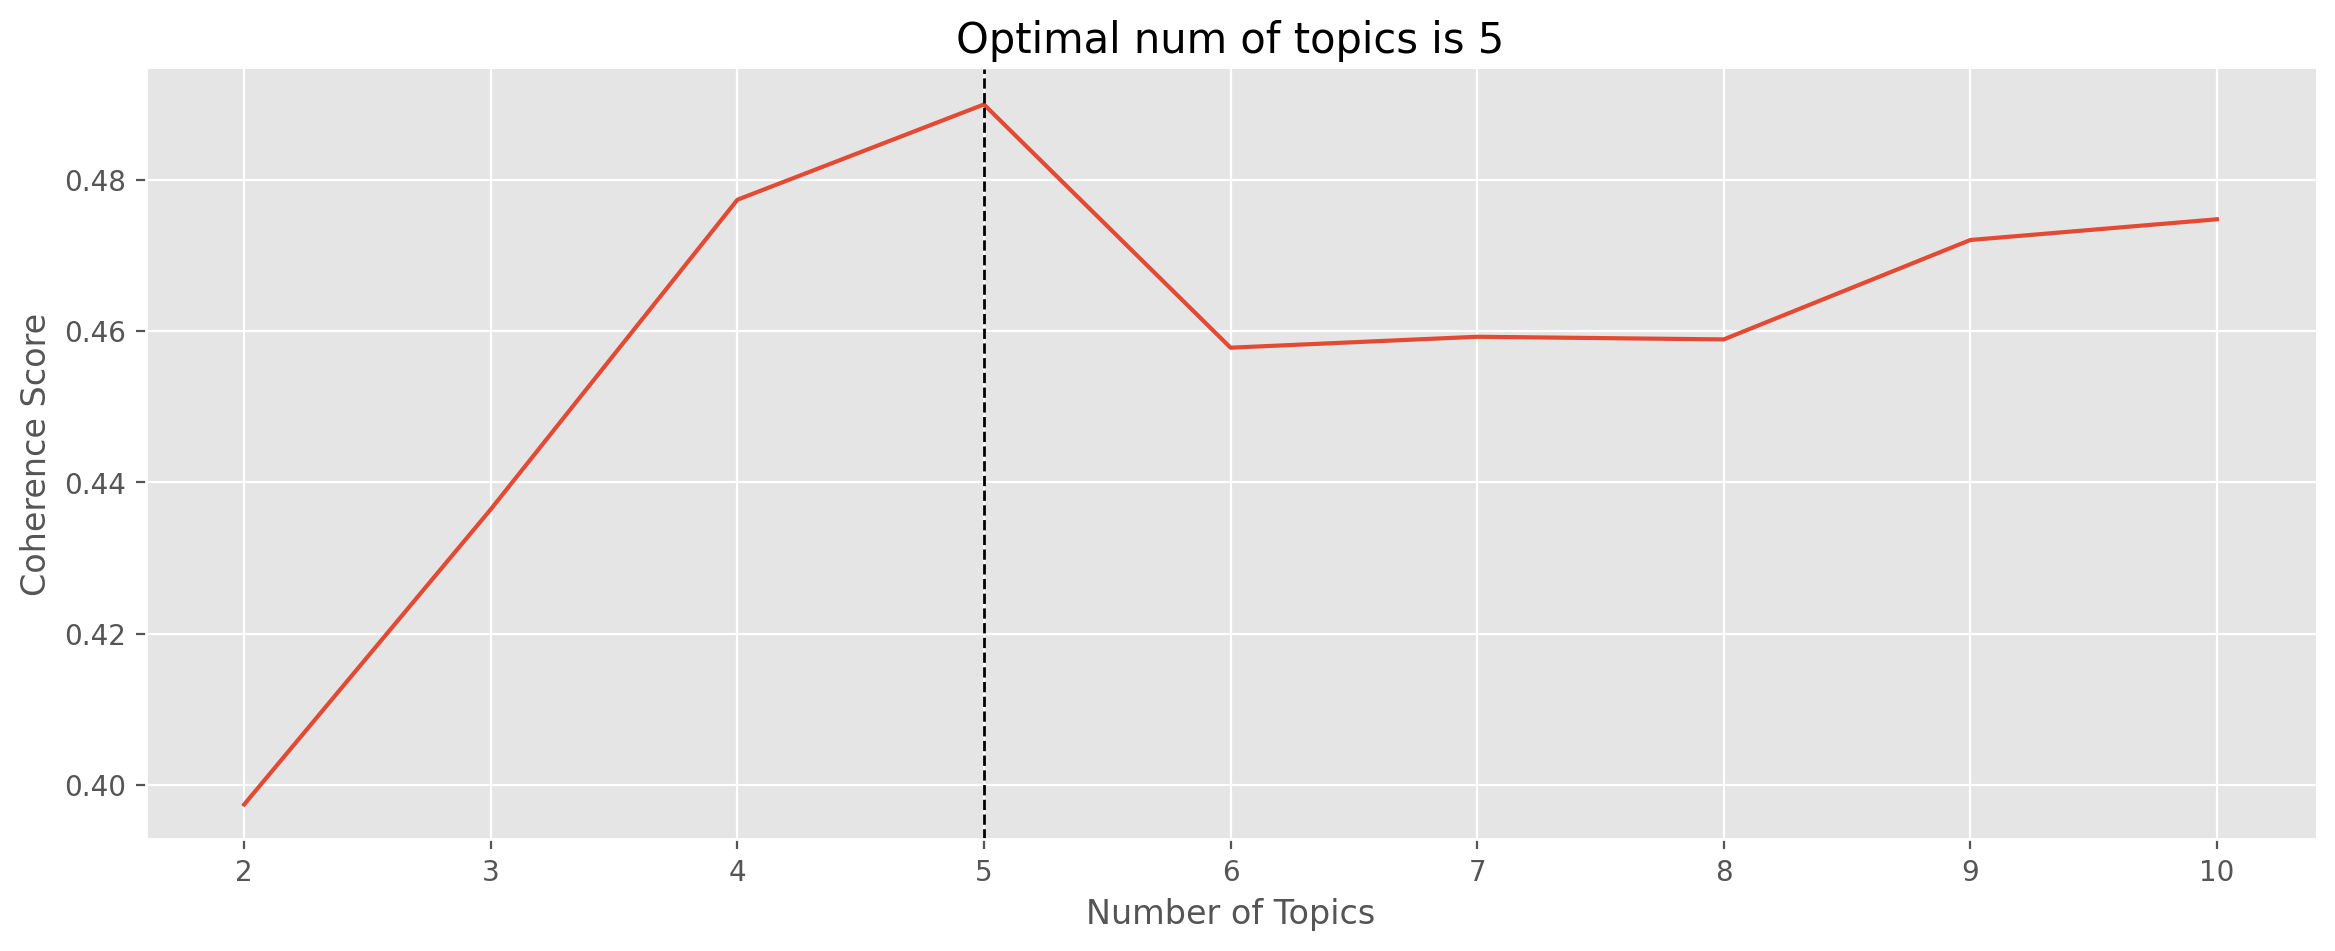

In [16]:
# Plot the coherence scores
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(topics_range, coherence_scores)
plt.axvline(x=optimal_num_topics, linestyle='--', color='black', linewidth=1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(range(2, 11, 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Optimal num of topics is {optimal_num_topics}', size=15)
plt.show()

In [24]:
# Train NMF model with the optimal number of topics
nmf_model = NMF(n_components=optimal_num_topics, random_state=42, max_iter=1000)
nmf_model.fit(tfidf_matrix)

NMF(max_iter=1000, n_components=5, random_state=42)

In [26]:
# Print the topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Top 10 words for the topic
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: gratis, banget, transfer, transaksi, aplikasinya, cepat, mudah, aplikasi, gopay, mantap
Topic 1: aman, transaksi, gopay, cepat, apk, aplikasinya, mudah, banget, aplikasi, bagus
Topic 2: transaksi, aplikasinya, aplikasi, cepat, mudah, sip, bgt, gopay, banget, ok
Topic 3: pembayaran, transfer, terimakasih, banget, cepat, transaksi, gopay, mudah, aplikasi, membantu
Topic 4: luck, banget, mudah, apk, gopay, very, app, aplikasi, job, good


In [34]:
coherence_model = CoherenceModel(topics=topic_words, texts=df['cleaned_content'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence score: {coherence_score:.4f}')

python(10439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(10445) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Coherence score: 0.4748
